In [4]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import make_scorer
from joblib import dump, load
import pandas as pd
from joblib import load
import numpy as np

data = pd.read_csv("data/final_data.csv")

data['Year']=data['Year'].astype('category')
data['Month']=data['Month'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

data = data[data['Cancelled'] != 1]

min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]

data = data.dropna(subset=['ArrDelay'])

min_delay = data["ArrDelay"].min() 
data['LogArrDelay'] = np.log1p(data["ArrDelay"] - min_delay +1)

X = data.drop(columns=['Cancelled', 'DepDelay', 'ArrDelay','LogArrDelay'])
y = data['LogArrDelay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns and convert them to category type if needed
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
# Convert categorical columns in the train and test sets to categorical dtype for LightGBM
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
# Set up LightGBM dataset with categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_data)

In [5]:
# 加载已训练好的 LightGBM 模型
model = load("lightgbm_model.joblib")

# 加载模型
booster = lgb.Booster(model_file='lightgbm_model.txt')

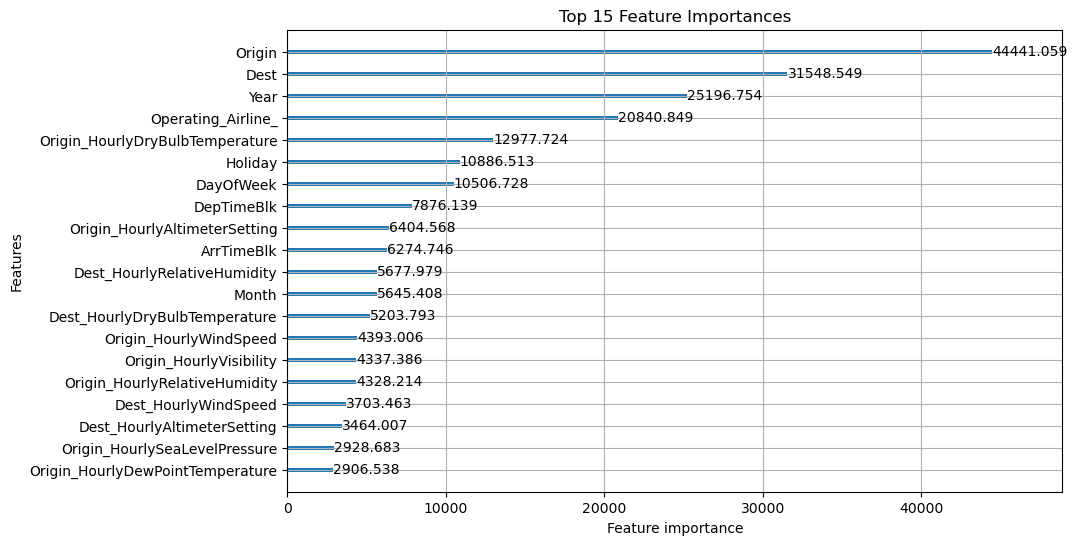

In [8]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.show()

In [108]:
import pandas as pd
import lightgbm as lgb

# 获取特征重要性，按增益计算
feature_importances = pd.DataFrame({
    'Feature': model.feature_name_,
    'Importance': model.booster_.feature_importance(importance_type='gain')
})

# 按重要性排序并输出最不重要的特征（前10个）
least_important_features = feature_importances.sort_values(by='Importance').head(10)
print("Not important features based on gain:")
print(least_important_features)

Not important features based on gain:
                           Feature   Importance
27        Dest_HourlyWindGustSpeed   371.540588
17      Origin_HourlyWindGustSpeed   488.933912
8                         Distance  1277.827083
22        Dest_HourlyPrecipitation  1799.240268
12      Origin_HourlyPrecipitation  1865.828936
25           Dest_HourlyVisibility  1938.081520
26        Dest_HourlyWindDirection  2063.425915
20  Dest_HourlyDewPointTemperature  2081.430417
16      Origin_HourlyWindDirection  2232.882885
24     Dest_HourlySeaLevelPressure  2366.785287


D:\anaconda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


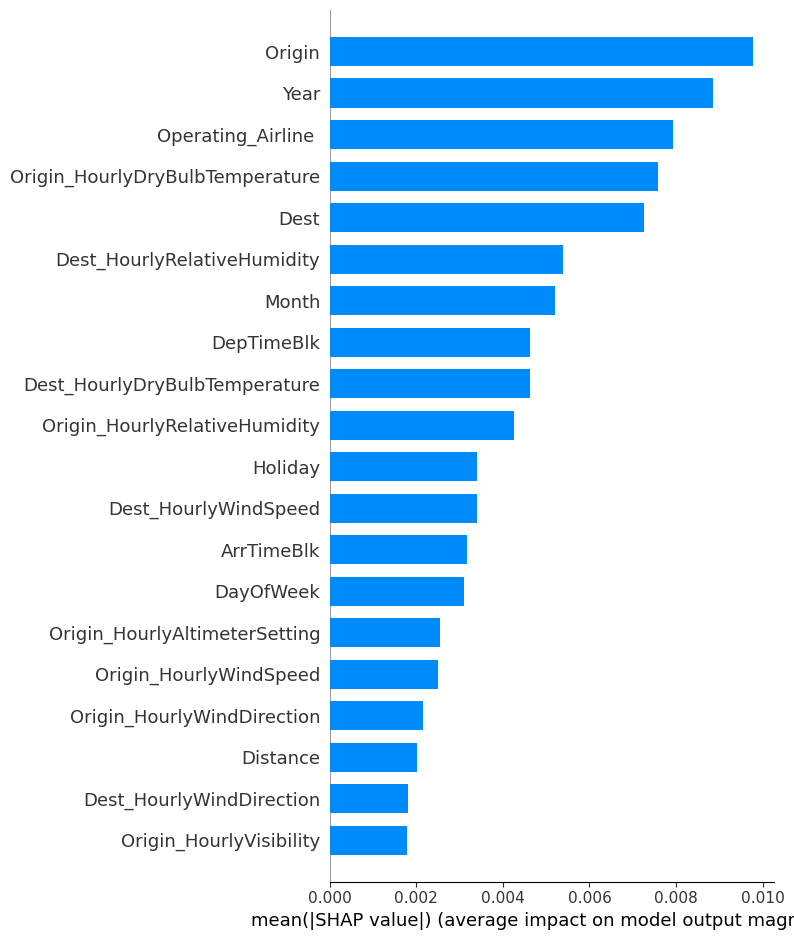

In [7]:
import shap

# 使用 SHAP 值解释模型
explainer = shap.TreeExplainer(model) 
sample_X = X.sample(n=10000, random_state=42)  # 抽样 10,000 个样本
shap_values = explainer.shap_values(sample_X)

# 绘制 SHAP Summary Plot，查看各个特征的类别如何影响预测
shap.summary_plot(shap_values, X, plot_type="bar")

In [23]:
# 获取 'Origin' 的 SHAP 值
origin_shap_values = pd.DataFrame({
    'Origin': sample_X['Origin'], 
    'SHAP Value': shap_values[:, X.columns.get_loc('Origin')]
})

# 计算每个类别的平均 SHAP 值
mean_shap_values = origin_shap_values.groupby('Origin')['SHAP Value'].mean()

# 将平均 SHAP 值分为正向和负向，分别排序
positive_mean_shap = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)
negative_mean_shap = mean_shap_values[mean_shap_values < 0].sort_values()

# 显示正向和负向影响最大的前五个类别
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
Origin
MQT    0.043168
RDM    0.027766
SBP    0.021310
CSG    0.020846
BQN    0.019514
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
Origin
BGR   -0.042139
CIU   -0.038619
ELM   -0.035179
RST   -0.032907
BRW   -0.032467
Name: SHAP Value, dtype: float64


In [26]:
# 获取 'Dest' 的 SHAP 值
origin_shap_values = pd.DataFrame({
    'Dest': sample_X['Dest'], 
    'SHAP Value': shap_values[:, X.columns.get_loc('Dest')]
})

# 计算每个类别的平均 SHAP 值
mean_shap_values = origin_shap_values.groupby('Dest')['SHAP Value'].mean()

# 将平均 SHAP 值分为正向和负向，分别排序
positive_mean_shap = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)
negative_mean_shap = mean_shap_values[mean_shap_values < 0].sort_values()

# 显示正向和负向影响最大的前五个类别
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
Dest
ASE    0.035252
PGD    0.021953
PVU    0.020688
MIA    0.016555
CSG    0.014895
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
Dest
BLI   -0.027257
DLH   -0.026458
OTZ   -0.024745
UIN   -0.024273
SUN   -0.024214
Name: SHAP Value, dtype: float64


In [101]:
# 创建示例数据: 芝加哥的大机场和小机场
sample_data = pd.read_excel("sampledata.xlsx")
for col in categorical_features:
    sample_data[col] = sample_data[col].astype('category')
sample_data

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,NaN,NaN,NaN,NaN,ORD,LAX,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,MDW,LAX,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
prediction = model.predict(sample_data)
min_delay = -253.0
# 将 LogArrDelay 转换回 ArrDelay
y_pred_delay = np.expm1(prediction ) + min_delay - 1
# 计算延误时间的增长量
delay_increase = y_pred_delay[1] - y_pred_delay[0]

# 计算延误时间的增长比例
delay_increase_ratio = delay_increase / y_pred_delay[0]

print("Delay time increase:", delay_increase)
print("Delay time increase ratio:", delay_increase_ratio)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Delay time increase: -7.9828815257665156
Delay time increase ratio: -0.6033251221461323


In [22]:
# 获取 'Operating_Airline' 的 SHAP 值
origin_shap_values = pd.DataFrame({
    'Operating_Airline ': sample_X['Operating_Airline '], 
    'SHAP Value': shap_values[:, X.columns.get_loc('Operating_Airline ')]
})

# 计算每个类别的平均 SHAP 值
mean_shap_values = origin_shap_values.groupby('Operating_Airline ')['SHAP Value'].mean()

# 将平均 SHAP 值分为正向和负向，分别排序
positive_mean_shap = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)
negative_mean_shap = mean_shap_values[mean_shap_values < 0].sort_values()

# 显示正向和负向影响最大的前五个类别
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
Operating_Airline 
B6    0.022698
AX    0.022688
G4    0.021060
C5    0.019382
EM    0.019382
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
Operating_Airline 
YX   -0.017573
9E   -0.015772
DL   -0.010808
VX   -0.009263
UA   -0.006325
Name: SHAP Value, dtype: float64


In [56]:
# 创建示例数据: 运行公司不同
sample_data = pd.read_excel("sampledata.xlsx")
for col in categorical_features:
    sample_data[col] = sample_data[col].astype('category')
sample_data

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,NaN,NaN,NaN,DL,ORD,JFK,1500-1559,NaN,740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Around Newyear
1,NaN,NaN,NaN,B6,ORD,JFK,1500-1559,NaN,740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Around Newyear


In [60]:
prediction = model.predict(sample_data)
min_delay = -253.0
# 将 LogArrDelay 转换回 ArrDelay
y_pred_delay = np.expm1(prediction ) + min_delay - 1
# 计算延误时间的增长量
delay_increase = y_pred_delay[1] - y_pred_delay[0]

# 计算延误时间的增长比例
delay_increase_ratio = delay_increase / y_pred_delay[0]

print("Delay time increase:", delay_increase)
print("Delay time increase ratio:", delay_increase_ratio)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Delay time increase: 20.00904573474179
Delay time increase ratio: 1.4080258154796446


In [112]:
# 获取 'Holiday' 的 SHAP 值
origin_shap_values = pd.DataFrame({
    'Holiday': sample_X['Holiday'], 
    'SHAP Value': shap_values[:, X.columns.get_loc('Holiday')]
})

# 计算每个类别的平均 SHAP 值
mean_shap_values = origin_shap_values.groupby('Holiday')['SHAP Value'].mean()

# 将平均 SHAP 值分为正向和负向，分别排序
positive_mean_shap = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)
negative_mean_shap = mean_shap_values[mean_shap_values < 0].sort_values()

# 显示正向和负向影响最大的前五个类别
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
Holiday
Around Newyear         0.017407
Around Christmas       0.008393
Before Thanksgiving    0.002872
Around Thanksgiving    0.000314
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
Holiday
Between Thanksgiving and Christmas   -0.002156
After Newyear                        -0.000335
Name: SHAP Value, dtype: float64


In [126]:
# 创建示例数据: 节日
sample_data = pd.read_excel("sampledata.xlsx")
for col in categorical_features:
    sample_data[col] = sample_data[col].astype('category')
sample_data

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,NaN,NaN,NaN,NaN,ORD,JFK,1500-1559,NaN,740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Between Thanksgiving and Christmas
1,NaN,NaN,NaN,NaN,ORD,JFK,1500-1559,NaN,740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Around Newyear


In [127]:
model.predict(sample_data)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


array([5.62053905, 5.63194568])

In [128]:
prediction = model.predict(sample_data)
min_delay = -253.0
# 将 LogArrDelay 转换回 ArrDelay
y_pred_delay = np.expm1(prediction ) + min_delay - 1
# 计算延误时间的增长量
delay_increase = y_pred_delay[1] - y_pred_delay[0]

# 计算延误时间的增长比例
delay_increase_ratio = delay_increase / y_pred_delay[0]

print("Delay time increase:", delay_increase)
print("Delay time increase ratio:", delay_increase_ratio)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Delay time increase: 3.166689847163184
Delay time increase ratio: 0.15052136423173762


In [131]:
# 获取 'Holiday' 的 SHAP 值
origin_shap_values = pd.DataFrame({
    'DayOfWeek': sample_X['DayOfWeek'], 
    'SHAP Value': shap_values[:, X.columns.get_loc('DayOfWeek')]
})

# 计算每个类别的平均 SHAP 值
mean_shap_values = origin_shap_values.groupby('DayOfWeek')['SHAP Value'].mean()

# 将平均 SHAP 值分为正向和负向，分别排序
positive_mean_shap = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)
negative_mean_shap = mean_shap_values[mean_shap_values < 0].sort_values()

# 显示正向和负向影响最大的前五个类别
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
DayOfWeek
1    0.003780
7    0.002451
5    0.001508
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
DayOfWeek
6   -0.003380
2   -0.002058
3   -0.001697
4   -0.001691
Name: SHAP Value, dtype: float64


In [132]:
# 获取 'Holiday' 的 SHAP 值
origin_shap_values = pd.DataFrame({
    'DepTimeBlk': sample_X['DepTimeBlk'], 
    'SHAP Value': shap_values[:, X.columns.get_loc('DepTimeBlk')]
})

# 计算每个类别的平均 SHAP 值
mean_shap_values = origin_shap_values.groupby('DepTimeBlk')['SHAP Value'].mean()

# 将平均 SHAP 值分为正向和负向，分别排序
positive_mean_shap = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)
negative_mean_shap = mean_shap_values[mean_shap_values < 0].sort_values()

# 显示正向和负向影响最大的前五个类别
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
DepTimeBlk
1800-1859    0.005457
1600-1659    0.004380
1700-1759    0.004348
1900-1959    0.004294
1500-1559    0.003914
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
DepTimeBlk
0001-0559   -0.016247
0600-0659   -0.012667
0700-0759   -0.006992
0800-0859   -0.002938
0900-0959   -0.001325
Name: SHAP Value, dtype: float64


In [96]:
# Display unique values in the "Origin_HourlyVisibility" column to see its range
X["Origin_HourlyVisibility"].unique()

array([16.093     ,  9.656     ,  0.402     , ...,  2.98573684,
       12.143     , 12.517     ])

In [99]:
# 能见度降低
sample_data = pd.read_excel("sampledata.xlsx")
for col in categorical_features:
    sample_data[col] = sample_data[col].astype('category')
sample_data

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,NaN,NaN,NaN,NaN,ORD,JFK,NaN,NaN,740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,ORD,JFK,NaN,NaN,740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
prediction = model.predict(sample_data)
min_delay = -253.0
# 将 LogArrDelay 转换回 ArrDelay
y_pred_delay = np.expm1(prediction ) + min_delay - 1
# 计算延误时间的增长量
delay_increase = y_pred_delay[1] - y_pred_delay[0]

# 计算延误时间的增长比例
delay_increase_ratio = delay_increase / y_pred_delay[0]

print("Delay time increase:", delay_increase)
print("Delay time increase ratio:", delay_increase_ratio)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Delay time increase: 2.6760270187232322
Delay time increase ratio: 0.14478312512440666


In [103]:
# Display unique values in the "Origin_HourlyVisibility" column to see its range
X["Origin_HourlyDryBulbTemperature"].unique()

array([-6.1       , -1.1       ,  2.8       , ...,  7.35384615,
       10.49411765,  5.16842105])

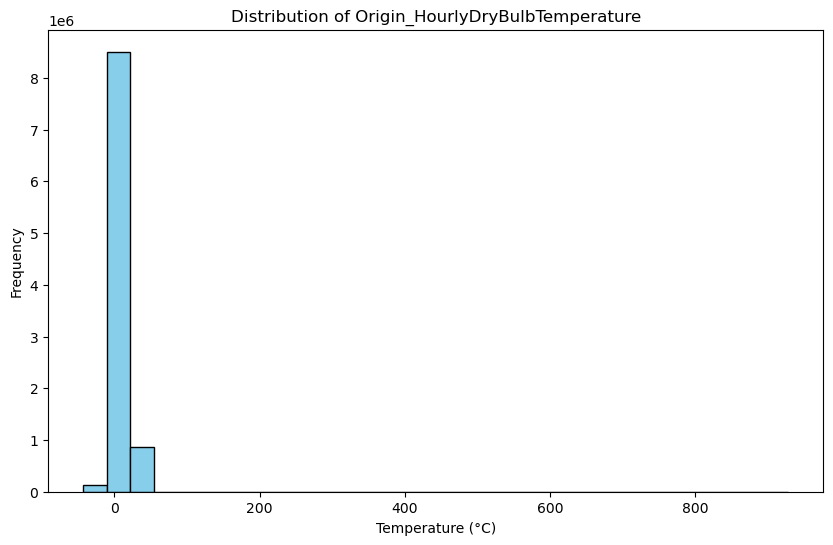

In [105]:
import matplotlib.pyplot as plt

# 假设 X 是已经包含 Origin_HourlyDryBulbTemperature 列的数据集
# 绘制 Origin_HourlyDryBulbTemperature 的分布图
plt.figure(figsize=(10, 6))
plt.hist(X["Origin_HourlyDryBulbTemperature"].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Origin_HourlyDryBulbTemperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

In [106]:
# 气温降低
sample_data = pd.read_excel("sampledata.xlsx")
for col in categorical_features:
    sample_data[col] = sample_data[col].astype('category')
sample_data

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,NaN,NaN,NaN,NaN,ORD,LAX,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,ORD,LAX,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
prediction = model.predict(sample_data)
min_delay = -253.0
# 将 LogArrDelay 转换回 ArrDelay
y_pred_delay = np.expm1(prediction ) + min_delay - 1
# 计算延误时间的增长量
delay_increase = y_pred_delay[1] - y_pred_delay[0]

# 计算延误时间的增长比例
delay_increase_ratio = delay_increase / y_pred_delay[0]

print("Delay time increase:", delay_increase)
print("Delay time increase ratio:", delay_increase_ratio)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Delay time increase: 6.7433388044725575
Delay time increase ratio: 0.49928152069480114
